This notebook is going to clean up the sympy work to get the voltage and current equations.

Once this is cleaned up, I can modify to correctly handle the three phase quantities.

- TODO: how do I handle the line-line line-neutral transformations correctly?
- TODO: can I output my functions more easily than cutting and pasting? evalf?
- TODO: do we see a difference between Ib and Ic in the high duty cycle regime of a full pull?

Notes

- I_c should match what VESC reports
- V_c should match q-axis current from VESC
- I_c V_c looks like I_b V_b / sqrt(3)

In [1]:
import sympy 
sympy.init_printing()

Ib = sympy.symbols('I_b', positive=True)           # battery current during motoring
Ic = sympy.symbols('I_c', positive=True)           # motor current
Vb = sympy.symbols('V_b', positive=True)           # battery voltage
Vc = sympy.symbols('V_c', positive=True)           # motor voltage line to line (should be line phase?)
Rm = sympy.symbols('R_m', positive=True)           # single phase motor resistance
k = sympy.symbols('k', positive=True)              # line to line voltage constant
omega = sympy.symbols('omega', positive=True)      # rotor angular velocity
Rb = sympy.symbols('R_b', positive=True)           # battery internal resistance
Voc = sympy.symbols('V_oc', positive=True)         # battery open circuit voltage
Imm = sympy.symbols('I_mm', positive=True)         # controller maximum current
Ibm = sympy.symbols('I_bm', positive=True)         # battery maximum current
torque = sympy.symbols('tau')                      # motor torque

power_eq = sympy.Eq(Vb * Ib, Vc * Ic * 3 / 2)                    # controller energy balance
#power_eq = sympy.Eq(Vb * Ib, Vc * Ic)                    # controller energy balance
controller_loop = sympy.Eq(Vc, Ic * Rm + k * omega)              # controller side voltage loop
battery_loop = sympy.Eq(Voc, Ib * Rb + Vb)                       # battery side voltage loop
# set controller current to max for first regime solution
regime_1_eq = sympy.Eq(Ic, Imm)  
# TODO: should Ib = Ibm regime be here?
regime_2_eq = sympy.Eq(Ib, Ibm)
# set battery and peak motor voltages equal for last regime
regime_3_eq = sympy.Eq(Vb, Vc)

simple_eq = sympy.Eq(Vc, Ic * Rm + k * omega)
torque_eq = sympy.Eq(torque, k * Ic) # this needs correction factor for three phase

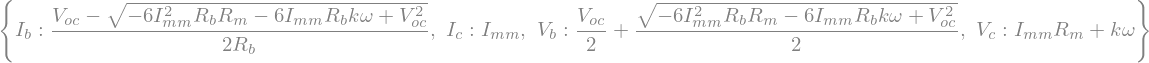

In [2]:
# solve for phase current limited regime
phase_limit = sympy.solve([power_eq, battery_loop, controller_loop, regime_1_eq], exclude=[Rb, Rm, k, Imm, Voc])[0]
phase_limit#[Ib]

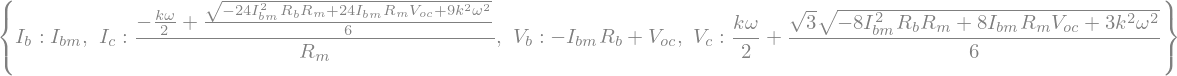

In [3]:
# solve for phase current limited regime
battery_limit = sympy.solve([power_eq, battery_loop, controller_loop, regime_2_eq], exclude=[Rb, Rm, k, Ibm, Voc])[0]
battery_limit#[Ic]

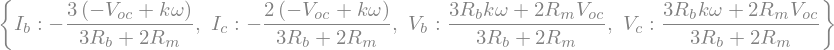

In [4]:
duty_limit = sympy.solve([power_eq, battery_loop, controller_loop, regime_3_eq], exclude=[Rb, Rm, k, Voc])[0]
duty_limit#[Ib]

In [5]:
ev_system = {Rb: 0.141, Voc:58, Imm: 150, Ibm:100, Rm: 0.075, k:1.0}

# solve for crossover frequency from phase current to battery current limited
crossover_1_2 = sympy.solve(sympy.Eq(Ibm, phase_limit[Ib]), omega)[0]
omega_1_2 = crossover_1_2.evalf(subs=ev_system)

crossover_2_3 = sympy.solve(sympy.Eq(battery_limit[Ic], duty_limit[Ic]), omega)[0]
omega_2_3 = crossover_2_3.evalf(subs=ev_system)

crossover_3 = sympy.solve(sympy.Eq(0, duty_limit[Ic]), omega)[0]
omega_3 = crossover_3.evalf(subs=ev_system)

print(omega_1_2, omega_2_3, omega_3)

8.26111111111111 38.9000000000000 58.0000000000000


In [6]:
import numpy as np
import matplotlib.pyplot as plt
regime_1_omega = np.linspace(0, float(omega_1_2), 100)
regime_2_omega = np.linspace(float(omega_1_2), float(omega_2_3), 100)
regime_3_omega = np.linspace(float(omega_2_3), float(omega_3), 100)

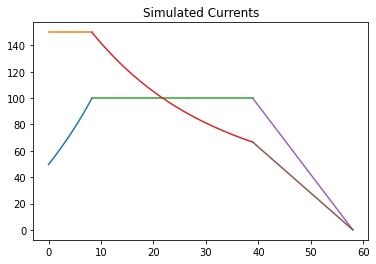

In [11]:
Ib_1 = list(map(sympy.lambdify(omega, phase_limit[Ib].subs(ev_system)), regime_1_omega))   # phase limited battery current
Ic_1 = list(map(sympy.lambdify(omega, phase_limit[Ic].subs(ev_system)), regime_1_omega))
Ib_2 = list(map(sympy.lambdify(omega, battery_limit[Ib].subs(ev_system)), regime_2_omega))
Ic_2 = list(map(sympy.lambdify(omega, battery_limit[Ic].subs(ev_system)), regime_2_omega))   # battery limited phase current
Ic_3 = list(map(sympy.lambdify(omega, duty_limit[Ib].subs(ev_system)), regime_3_omega))
Ib_3 = list(map(sympy.lambdify(omega, duty_limit[Ic].subs(ev_system)), regime_3_omega))

plt.plot(regime_1_omega, Ib_1)
plt.plot(regime_1_omega, Ic_1)
plt.plot(regime_2_omega, Ib_2)
plt.plot(regime_2_omega, Ic_2)
plt.plot(regime_3_omega, Ic_3)
plt.plot(regime_3_omega, Ib_3)
plt.title('Simulated Currents')
plt.show()

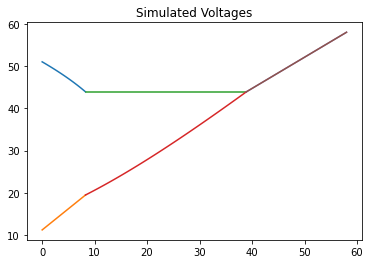

In [13]:
Vb_1 = list(map(sympy.lambdify(omega, phase_limit[Vb].subs(ev_system)), regime_1_omega))   # phase limited battery current
Vc_1 = list(map(sympy.lambdify(omega, phase_limit[Vc].subs(ev_system)), regime_1_omega))
Vb_2 = list(map(sympy.lambdify(omega, battery_limit[Vb].subs(ev_system)), regime_2_omega))
Vc_2 = list(map(sympy.lambdify(omega, battery_limit[Vc].subs(ev_system)), regime_2_omega))   # battery limited phase current
Vc_3 = list(map(sympy.lambdify(omega, duty_limit[Vb].subs(ev_system)), regime_3_omega))
Vb_3 = list(map(sympy.lambdify(omega, duty_limit[Vc].subs(ev_system)), regime_3_omega))


plt.plot(regime_1_omega, Vb_1)
plt.plot(regime_1_omega, Vc_1)
plt.plot(regime_2_omega, Vb_2)
plt.plot(regime_2_omega, Vc_2)
plt.plot(regime_3_omega, Vc_3)
plt.plot(regime_3_omega, Vb_3)
plt.title('Simulated Voltages')
plt.show()